In [1]:
import xupy as xp
from numpy.ma import masked_array
import matplotlib.pyplot as plt 

from ekarus.e2e.cascading_stage_ao_class import CascadingAO
from ekarus.e2e.utils import my_fits_package as myfits
from ekarus.e2e.utils.image_utils import reshape_on_mask

import os.path as op


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
cascao = CascadingAO(tn='cascading_8m')

def plot_masked_array(ma, id=None):
    ma_id = ma.copy()
    if id is not None:
        ma_id = ma[id]
    marray = masked_array(ma_id.data,mask=ma_id.mask)
    plt.imshow(marray,origin='lower',cmap='RdBu')
    plt.colorbar()
    plt.axis('off')

In [3]:
prf = ''
ma_atmo_phases, _, res1_phases, det1_frames, rec1_modes, dm1_cmds, _, res2_phases, det2_frames, rec2_modes, dm2_cmds = cascao.load_telemetry_data(save_prefix=prf)

In [22]:
KL = myfits.read_fits(op.join(cascao.savecalibpath,'DM1_KLmodes.fits'))
KL2 = myfits.read_fits(op.join(cascao.savecalibpath,'DM2_KLmodes.fits'))
phase2modes = xp.linalg.pinv(KL.T)

def get_modes(ma,id):
    im_data = ma[id].data
    phase = xp.array(im_data[~ma[id].mask])
    ph_rms = xp.sqrt(xp.sum(phase**2)/len(phase))
    modes = phase2modes @ phase
    rec_phase = KL.T @ modes
    rec_phase_2d = reshape_on_mask(rec_phase, xp.asarray(ma[id].mask))
    rec_ma = masked_array(xp.asnumpy(rec_phase_2d), ma[id].mask)
    return modes, rec_ma, ph_rms

In [31]:
atmo_modes, rec_atmo, atmo_rms = get_modes(ma_atmo_phases,-1)
res1_modes, rec_ph1, res1_rms = get_modes(res1_phases,-1)
res2_modes, rec_ph2, res2_rms = get_modes(res2_phases,-1)

print(xp.sum(xp.abs(atmo_modes)),xp.sum(xp.abs(res1_modes)),xp.sum(xp.abs(res2_modes)))
print(xp.sum(xp.abs(atmo_modes)*xp.std(KL.T,axis=0)),xp.sum(xp.abs(res1_modes)*xp.std(KL.T,axis=0)),xp.sum(xp.abs(res2_modes)*xp.std(KL.T,axis=0)))
print(atmo_rms, res1_rms, res2_rms)

6.559042e-06 1.0189684e-06 8.483821e-07
6.5590425e-06 1.0189688e-06 8.4838246e-07
7.399945e-07 7.534339e-08 6.662864e-08


In [26]:
mask = cascao.cmask.copy()
# m2c1 = myfits.read_fits(op.join(cascao.savecalibpath,'DM1_m2c.fits'))
# m2c2 = myfits.read_fits(op.join(cascao.savecalibpath,'DM2_m2c.fits'))

# c2m1 = xp.linalg.pinv(m2c1[:rec1_modes.shape[1],:])
# c2m2 = xp.linalg.pinv(m2c2[:rec2_modes.shape[1],:])

# rec1_kls = c2m1 @ rec1_modes[-1]
rec1_phase = KL[:rec1_modes.shape[1],:].T @ rec1_modes[-1]
rec1_phase_2d = reshape_on_mask(rec1_phase, mask)
rec1_ma = masked_array(xp.asnumpy(rec1_phase_2d), xp.asnumpy(mask))
# rec2_kls = c2m2 @ rec2_modes[-1]
rec2_phase = KL2[:rec2_modes.shape[1],:].T @ rec2_modes[-1]
rec2_phase_2d = reshape_on_mask(rec2_phase, mask)
rec2_ma = masked_array(xp.asnumpy(rec2_phase_2d), xp.asnumpy(mask))

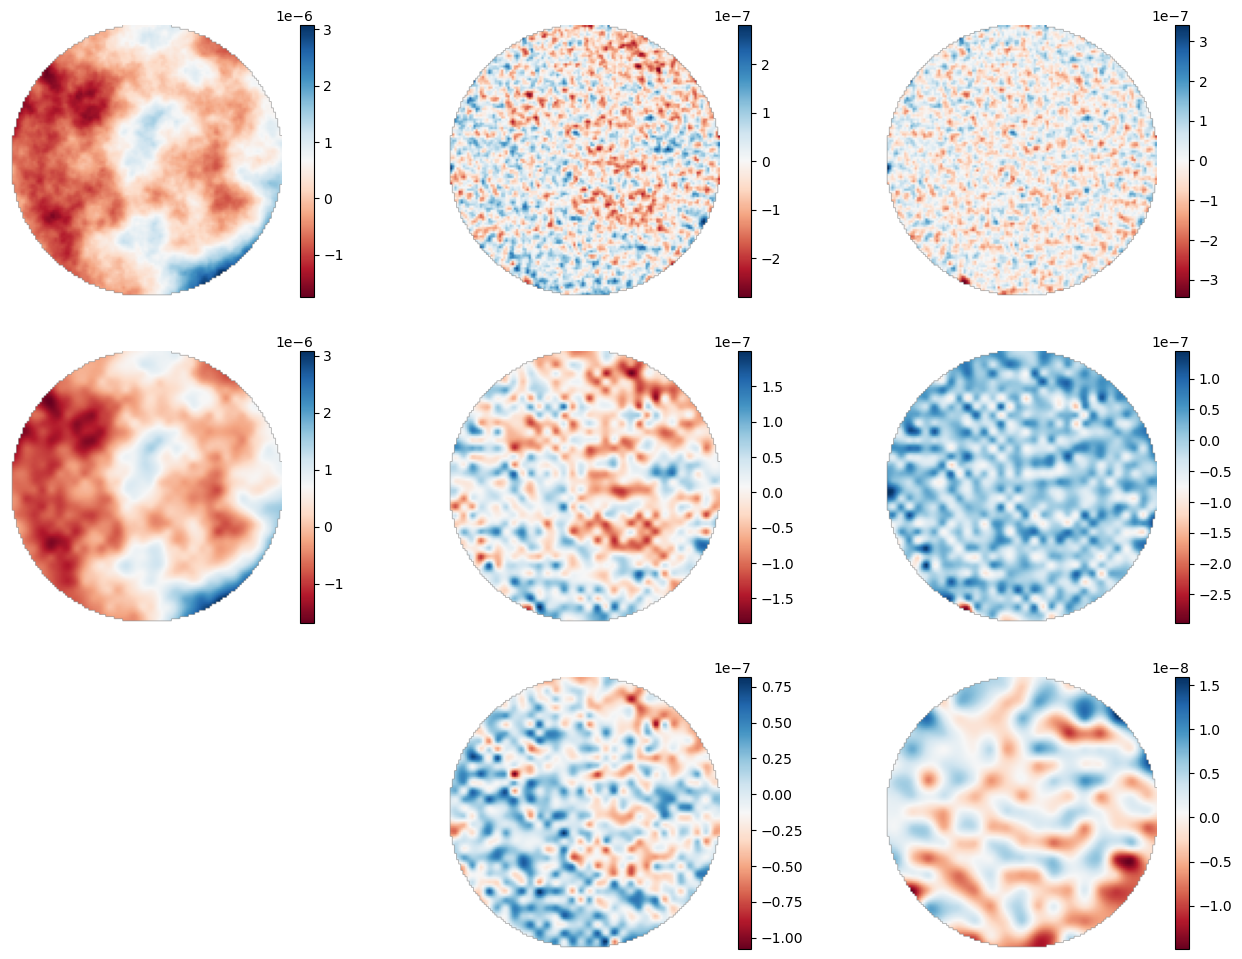

In [27]:
plt.figure(figsize=(16,12))
plt.subplot(3,3,1)
plot_masked_array(ma_atmo_phases,-1)
plt.subplot(3,3,2)
plot_masked_array(res1_phases,-1)
plt.subplot(3,3,3)
plot_masked_array(res2_phases,-1)
plt.subplot(3,3,4)
plot_masked_array(rec_atmo)
plt.subplot(3,3,5)
plot_masked_array(rec_ph1)
plt.subplot(3,3,6)
plot_masked_array(rec_ph2)
plt.subplot(3,3,8)
plot_masked_array(rec1_ma)
plt.subplot(3,3,9)
plot_masked_array(rec2_ma)